<a href="https://colab.research.google.com/github/AUT-Student/NN-HW7/blob/main/NN_HW7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
from keras.models import Sequential
from keras.losses import BinaryCrossentropy
from keras.layers import Dense, Input, Flatten, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU, Conv2D, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizer_v2.adam import Adam

# Dataset

In [2]:
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

In [3]:
# train_dataset, valid_dataset, test_dataset = tfds.load(name='cats_vs_dogs', split=["train[:70%]", "train[70%:80%]", "train[80%:]"], as_supervised=True)
dataset = tfds.load(name='cats_vs_dogs', split=["train"], as_supervised=True)[0]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete8IWLX6/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [4]:
dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [5]:
def rescale(image):
  return tf.image.resize(image, [128, 128])/255

In [6]:
preprocessed_dataset = []
for data in dataset:#.take(10):
  raw_data = data[0]

  preprocessed_dataset.append(rescale(raw_data))

preprocessed_dataset = tf.stack(preprocessed_dataset)

In [7]:
preprocessed_dataset.shape

TensorShape([23262, 128, 128, 3])

# FCGAN

In [8]:
class DiscriminatorFCGAN(keras.Model):
  def __init__(self):
    super().__init__()
    self.model = Sequential([
                             Input((250, 250, 3)),
                             Flatten(),
                             Dense(256),
                             Dense(128),
                             Dense(64),
                             Dense(32),
                             Dense(2, activation="softmax")
    ])

  def call(self, inputs):
    return self.model.call(inputs)

In [ ]:
class GeneratorFCGAN(keras.Model):
  def __init(self):
    super().__init__()
    self.model = Sequential([
                             Input(1),
                             Dense(32),
                             Dense(64),
                             Dense(128),
                             Dense(256),
                             Reshape((250, 250, 3))
    ])

  def call(self, inputs):
    return self.molde.cakk(inputs)

In [ ]:
discriminator = DiscriminatorFCGAN()

In [ ]:
generator = GeneratorFCGAN()

# DCGAN

## Models

In [9]:
class GeneratorDCGAN(keras.Model):
  def __init__(self):
    super().__init__()

    self.model = Sequential([
                             Input(100),
                             Dense(8*8*256, use_bias=False),
                             Reshape((8, 8, 256)),

                             Conv2DTranspose(128, (5, 5), strides=(2,2), padding="same", use_bias=False),
                             BatchNormalization(),
                             LeakyReLU(),

                             Conv2DTranspose(64, (5, 5), strides=(2,2), padding="same", use_bias=False),
                             BatchNormalization(),
                             LeakyReLU(),

                             Conv2DTranspose(32, (5, 5), strides=(2,2), padding="same", use_bias=False),
                             BatchNormalization(),
                             LeakyReLU(),

                             Conv2DTranspose(3, (5,5), strides=(2,2), padding="same", use_bias=False, activation="sigmoid")
    ])

  def call(self, inputs):
    return self.model(inputs)

In [10]:
class DiscriminatorDCGAN(keras.Model):
  def __init__(self):
    super().__init__()

    self.model = Sequential([
                             Input((128, 128, 3)),

                             Conv2D(32, (5, 5), strides=(2,2), padding="same"),
                             LeakyReLU(),
                             Dropout(0.3),

                             Conv2D(64, (5, 5), strides=(2,2), padding="same"),
                             LeakyReLU(),
                             Dropout(0.3),

                             Conv2D(128, (5, 5), strides=(2,2), padding="same"),
                             LeakyReLU(),
                             Dropout(0.3),

                             Flatten(),
                             Dense(1)
    ])

  def call(self, inputs):
    return self.model.call(inputs)

## Loss Functions & Aptimizers

In [11]:
cross_entropy = BinaryCrossentropy(from_logits=True)

In [12]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [13]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Train

In [15]:
tf.config.run_functions_eagerly(True)

In [16]:
generator = GeneratorDCGAN()
discriminator = DiscriminatorDCGAN()

In [17]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, batch_size, noise_dim):
  # print(f"images.shape = {images.shape}")
  # print(f"batch_size = {batch_size}")

  noise = tf.random.normal([batch_size, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [18]:
def train(dataset, epochs, batch_size=32):

  for epoch in range(epochs):
    start = time.time()

    number_batches = int(len(dataset) / batch_size)

    for batch in range(number_batches):
      if batch%100==0: print(f"{round(batch*100/number_batches)}%")

      image_batch = dataset[batch*batch_size:(batch+1)*batch_size]

    # for image_batch in dataset:
      train_step(image_batch, batch_size=batch_size, noise_dim=100)

    # Produce images for the GIF as you go
    # display.clear_output(wait=True)
    # generate_and_save_images(generator,
    #                          epoch + 1,
    #                          seed)

    # Save the model every 15 epochs
    # if (epoch + 1) % 15 == 0:
    #   checkpoint.save(file_prefix = checkpoint_prefix)

    print(f'Time for epoch {epoch + 1} is {time.time()-start} sec')

  # Generate after the final epoch
  # display.clear_output(wait=True)
  # generate_and_save_images(generator,
  #                          epochs,
  #                          seed)

In [19]:
train(preprocessed_dataset, epochs=10, batch_size=64)

0%
28%
55%
83%
Time for epoch 1 is 69.84337711334229 sec
0%
28%
55%
83%
Time for epoch 2 is 60.89661908149719 sec
0%
28%
55%
83%
Time for epoch 3 is 59.50711131095886 sec
0%
28%
55%
83%
Time for epoch 4 is 59.906684160232544 sec
0%
28%
55%
83%
Time for epoch 5 is 59.443774938583374 sec
0%
28%
55%
83%
Time for epoch 6 is 59.44123840332031 sec
0%
28%
55%
83%
Time for epoch 7 is 59.49859261512756 sec
0%
28%
55%
83%
Time for epoch 8 is 59.46405553817749 sec
0%
28%
55%
83%
Time for epoch 9 is 59.46676588058472 sec
0%
28%
55%
83%
Time for epoch 10 is 59.49644660949707 sec


In [20]:
noise = tf.random.normal([1, 100])

noise_image = generator(noise, training=False)[0]

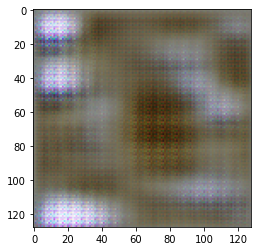

In [21]:
plt.imshow(noise_image, vmin=-1, vmax=+1)

In [22]:
discriminator(np.array([noise_image]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.2337032]], dtype=float32)>